**Gradient Descent Algorithm**

In [43]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [44]:
#Creating the training data in pairs of (x_i, y_i)
#We'll try to fit the straight line model to these data

data = np.array([[0.03, 0.19, 0.34,0.46,0.78,0.81,1.08,1.18,1.39,1.60,1.65,1.90],
                [0.67,0.85,1.05,1.00,1.40,1.50,1.30,1.54,1.55,1.68,1.73,1.60]])

In [45]:
#Defining the model which is just a straight line with an intercept of phi[0] and slope of phi[1]
def model(phi, x):
  y_pred = phi[0]+(phi[1] * x)
  return y_pred

In [46]:
def draw_model(data, model, phi, title = "None"):
  x_model = np.arange(0,2,0.01)
  y_model = model(phi, x_model)

  fig, ax = plt.subplots()
  ax.plot(data[0,:], data[1,:], 'bo')
  ax.plot(x_model, y_model, 'm-')
  ax.set_xlim([0,2]) ; ax.set_ylim([0,2])
  ax.set_xlabel('x') ; ax.set_ylabel('y')
  ax.set_aspect('equal')
  if title is not None:
    ax.set_title(title)
  plt.show()

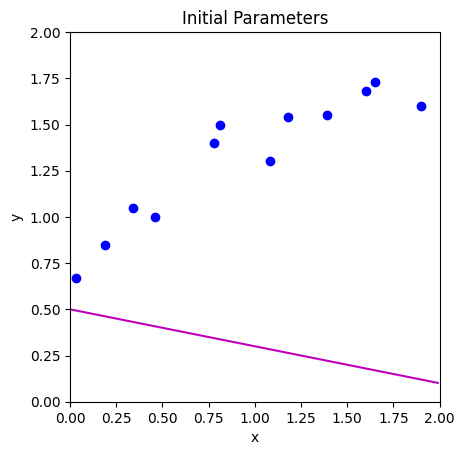

In [47]:
#Imitializing the parameters to some abitrary values nad drawing teh model
phi = np.zeros((2,1)) #craetes a 2 * 1 array and inializes it with zeros

phi[0] = 0.5
phi[1] = -0.2

draw_model(data, model, phi, "Initial Parameters")

#From the output visualized it is noted that the model does not fit the data

In [48]:
#Computing the sum of squares loss for the training data

def compute_loss(data_x, data_y, model, phi):
  pred_y = model(phi, data_x)
  loss = np.sum((pred_y - data_y)**2)
  return loss

In [49]:
#Testing if the result from compute_loss is correct
loss = compute_loss(data[0,:], data[1,:],model,np.array([[0.6],[-0.2]]))
print('Your loss = %3.3f, Correct loss = %3.3f'%(loss, 12.367))

#The output proves that the loss is correct

Your loss = 12.367, Correct loss = 12.367


In [50]:
#Plotting the loss function
def draw_loss_function(compute_loss, data, model,phi_iters = None) :  #Visualizes the loss over different values of intercepts and slopes
  #Defining pretty colormap
  my_colormap_vals_hex = ('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b')
  my_colormap_vals_dec = np.array([int(element, base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  # Make grid of intercept/slope values to plot
  intercepts_mesh, slopes_mesh = np.meshgrid(np.arange(0.0,2.0,0.02), np.arange(-1.0,1.0,0.002))
  loss_mesh = np.zeros_like(slopes_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(slopes_mesh):
     loss_mesh[idslope] = compute_loss(data[0,:], data[1,:], model, np.array([[intercepts_mesh[idslope]], [slope]]))

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(intercepts_mesh,slopes_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(intercepts_mesh,slopes_mesh,loss_mesh,40,colors=['#80808080'])
  if phi_iters is not None:
    ax.plot(phi_iters[0,:], phi_iters[1,:],'go-')
  ax.set_ylim([1,-1])
  ax.set_xlabel('Intercept'); ax.set_ylabel('Slope,')
  plt.show()


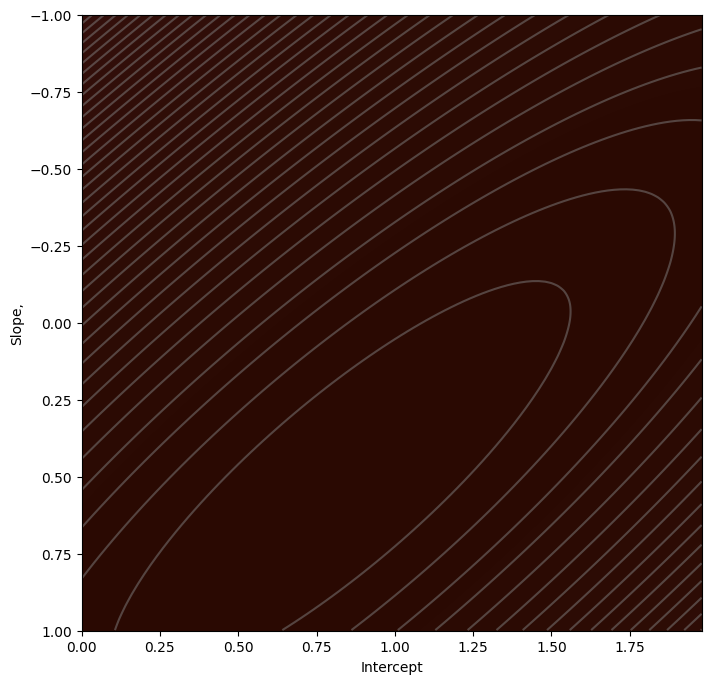

In [51]:
draw_loss_function(compute_loss, data, model)

In [52]:
#Computing the gradient for a given set of parameters
def compute_gradient(data_x, data_y, phi):
    dl_dphi0 = 2 * (phi[0] + phi[1] * data_x - data_y)
    dl_dphi1 = 2 * data_x * (phi[0] + phi[1] * data_x - data_y)

    return np.array([[np.sum(dl_dphi0)], [np.sum(dl_dphi1)]])


In [53]:
#computing gradient using the function defined above
gradient = compute_gradient(data[0,:],data[1,:], phi)
print("Your gradients: (%3.3f,%3.3f)"%(gradient[0],gradient[1]))
# Approximate the gradients with finite differences
delta = 0.0001
dl_dphi0_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[delta],[0]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
dl_dphi1_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[0],[delta]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
print("Approx gradients: (%3.3f,%3.3f)"%(dl_dphi0_est,dl_dphi1_est))
# There might be small differences in the last significant figure because finite gradients is an approximation

Your gradients: (-24.304,-29.122)
Approx gradients: (-24.303,-29.121)


In [54]:
def loss_function_1D(dist_prop, data, model, phi_start, search_direction):
  # Return the loss after moving this far
  return compute_loss(data[0,:], data[1,:], model, phi_start+ search_direction * dist_prop)

def line_search(data, model, phi, gradient, thresh=.00001, max_dist = 0.1, max_iter = 15, verbose=False):
    # Initialize four points along the range we are going to search
    a = 0
    b = 0.33 * max_dist
    c = 0.66 * max_dist
    d = 1.0 * max_dist
    n_iter  =0;

    # While we haven't found the minimum closely enough
    while np.abs(b-c) > thresh and n_iter < max_iter:
        # Increment iteration counter (just to prevent an infinite loop)
        n_iter = n_iter+1
        # Calculate all four points
        lossa = loss_function_1D(a, data, model, phi,gradient)
        lossb = loss_function_1D(b, data, model, phi,gradient)
        lossc = loss_function_1D(c, data, model, phi,gradient)
        lossd = loss_function_1D(d, data, model, phi,gradient)

        if verbose:
          print('Iter %d, a=%3.3f, b=%3.3f, c=%3.3f, d=%3.3f'%(n_iter, a,b,c,d))
          print('a %f, b%f, c%f, d%f'%(lossa,lossb,lossc,lossd))

        # Rule #1 If point A is less than points B, C, and D then halve points B,C, and D
        if np.argmin((lossa,lossb,lossc,lossd))==0:
          b = b/2
          c = c/2
          d = d/2
          continue;

        # Rule #2 If point b is less than point c then
        #                     then point d becomes point c, and
        #                     point b becomes 1/3 between a and new d
        #                     point c becomes 2/3 between a and new d
        if lossb < lossc:
          d = c
          b = a+ (d-a)/3
          c = a+ 2*(d-a)/3
          continue

        # Rule #2 If point c is less than point b then
        #                     then point a becomes point b, and
        #                     point b becomes 1/3 between new a and d
        #                     point c becomes 2/3 between new a and d
        a = b
        b = a+ (d-a)/3
        c = a+ 2*(d-a)/3

    # Return average of two middle points
    return (b+c)/2.0

In [55]:
def gradient_descent_step(phi, data, model):
  grad = compute_gradient(data, phi, model)

  #finding step size specified as alpha in the book
  step_size = line_search(data, phi, model, grad)

  phi_new = phi - step_size * grad


  return phi_new;

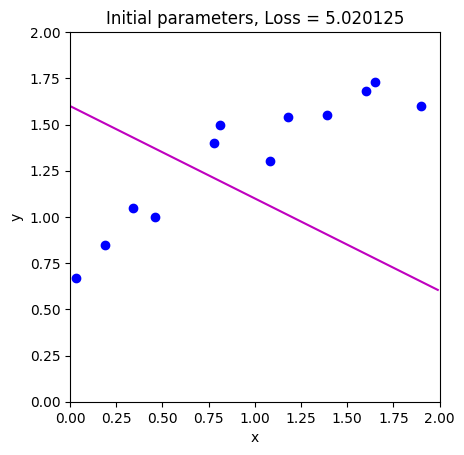

TypeError: 'function' object is not subscriptable

In [60]:
# Initialize the parameters and draw the model
n_steps = 10
phi_all = np.zeros((2, n_steps + 1))
phi_all[0, 0] = 1.6
phi_all[1, 0] = -0.5

# Measure loss and draw initial model
loss = compute_loss(data[0], data[1], model, phi_all[:, 0])
draw_model(data, model, phi_all[:, 0], "Initial parameters, Loss = %f" % (loss))

# Repeatedly take gradient descent steps
for c_step in range(n_steps):
    # Do gradient descent step
    phi_all[:, c_step + 1:c_step + 2] = gradient_descent_step(phi_all[:,c_step:c_step+1],data, model)
    # Measure loss and draw model
    loss = compute_loss(data[0], data[1], model, phi_all[:, c_step + 1:c_step + 2])
    draw_model(data, model, phi_all[:, c_step + 1], "Iteration %d, loss = %f" % (c_step + 1, loss))

# Draw the trajectory on the loss function
draw_loss_function(compute_loss, data, model, phi_all)

